In [1]:
import random 
import efc as efc
import numpy as np
import pandas as pd
import seaborn as sns

from efc import EnergyBasedFlowClassifier
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

verbose = False
%matplotlib inline

/home/leohmelo/venv/lib/python3.10/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/leohmelo/venv/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/leohmelo/venv/lib/python3.10/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/leohmelo/venv/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
silos_path = "./datasets/silos/"
silos_files = [f for f in listdir(silos_path) if isfile(join(silos_path, f))]

silos = {}
for silo in silos_files:
    silo_name = silo.replace(".csv.gz", "")
    silos[silo_name] = pd.read_csv(silos_path + silo)
    
    if(verbose):
        print(f"{silo_name} >>> \n{silos[silo_name]['Label'].value_counts()}")

In [3]:
def preprocess(X):
    cols = X.select_dtypes(include=[np.float64]).columns
    X[cols] = X[cols].astype(np.float32)

    X.fillna(0, inplace=True)
    X.replace(np.inf, 9999, inplace=True)
    
    return X

In [4]:
def average(lst):
    return sum(lst) / len(lst)

In [5]:
balanced = True 
def rebalance_agent(agent):
    agent_label_count = agent["Label"].value_counts().to_dict()
    benign_count = agent_label_count[0] 
    malicious_count = agent_label_count[1]
    
    if(balanced):
        if (benign_count > malicious_count):
            downsampled_0 = resample(
                                agent[agent.Label == 0], 
                                replace=False, 
                                n_samples=agent[agent.Label == 1].shape[0],
                                random_state=1337
                            )
            agent_balanced = pd.concat([downsampled_0, agent[agent.Label == 1]])
        elif (benign_count < malicious_count): 
            downsampled_1 = resample(
                                agent[agent.Label == 1], 
                                replace=False, 
                                n_samples=agent[agent.Label == 0].shape[0], 
                                random_state=1337
                            )
            agent_balanced = pd.concat([downsampled_1, agent[agent.Label == 0]])
        else:
            agent_balanced = agent
    else:
        agent_balanced = agent
    
    return agent_balanced

In [6]:
features_to_delete = [
     'DST_TO_SRC_SECOND_BYTES',
     'FTP_COMMAND_RET_CODE',
     'RETRANSMITTED_IN_PKTS',
     'RETRANSMITTED_IN_BYTES',
     'DNS_TTL_ANSWER',
     'SERVER_TCP_FLAGS',
     'DNS_QUERY_TYPE',
     'DNS_QUERY_ID',
     'SRC_TO_DST_SECOND_BYTES',
     'Unnamed: 0',
     'SRC_TO_DST_AVG_THROUGHPUT',
     'MIN_TTL',
     'SHORTEST_FLOW_PKT',
     'IN_BYTES',
     'MAX_TTL',
     'LONGEST_FLOW_PKT',
     'MAX_IP_PKT_LEN',
     'RETRANSMITTED_OUT_PKTS',
     'NUM_PKTS_128_TO_256_BYTES',
     'OUT_PKTS',
     'RETRANSMITTED_OUT_BYTES',
     'MIN_IP_PKT_LEN',
     'NUM_PKTS_256_TO_512_BYTES',
     'DURATION_IN',
     'Label'
]

0    658
1    658
Name: Label, dtype: int64
agent18 | cutoff = 318.23970743752943 
-------------------------------------------------------------------
               precision    recall  f1-score   support

           0       0.97      0.93      0.95      6157
           1       0.16      0.31      0.21       282

    accuracy                           0.90      6439
   macro avg       0.56      0.62      0.58      6439
weighted avg       0.93      0.90      0.91      6439



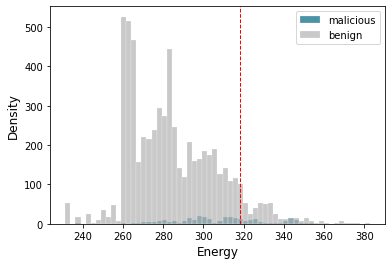

1    933
0    933
Name: Label, dtype: int64
agent11 | cutoff = 319.5508486984386 
-------------------------------------------------------------------
               precision    recall  f1-score   support

           0       0.50      0.94      0.65       400
           1       1.00      1.00      1.00     92190

    accuracy                           1.00     92590
   macro avg       0.75      0.97      0.82     92590
weighted avg       1.00      1.00      1.00     92590



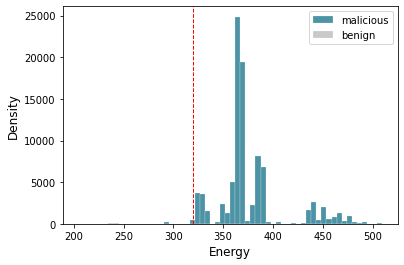

0    26712
1    26712
Name: Label, dtype: int64
agent8 | cutoff = 319.3490519539169 
-------------------------------------------------------------------
               precision    recall  f1-score   support

           0       0.84      0.95      0.89     19195
           1       0.89      0.70      0.79     11448

    accuracy                           0.86     30643
   macro avg       0.87      0.83      0.84     30643
weighted avg       0.86      0.86      0.85     30643



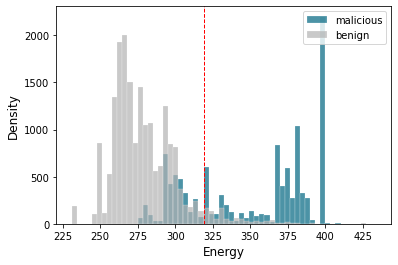

0    169
1    169
Name: Label, dtype: int64
agent7 | cutoff = 302.546258041324 
-------------------------------------------------------------------
               precision    recall  f1-score   support

           0       1.00      0.93      0.96    101072
           1       0.01      1.00      0.02        73

    accuracy                           0.93    101145
   macro avg       0.51      0.96      0.49    101145
weighted avg       1.00      0.93      0.96    101145



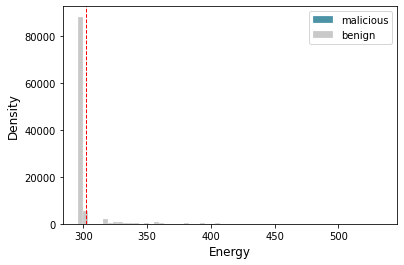

0    63870
1    63870
Name: Label, dtype: int64
agent5 | cutoff = 327.2825375042782 
-------------------------------------------------------------------
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    187168
           1       0.74      1.00      0.85     27373

    accuracy                           0.95    214541
   macro avg       0.87      0.97      0.91    214541
weighted avg       0.97      0.95      0.96    214541



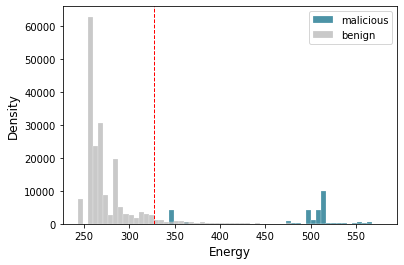

0    749
1    749
Name: Label, dtype: int64
agent19 | cutoff = 329.70525078372407 
-------------------------------------------------------------------
               precision    recall  f1-score   support

           0       0.96      0.93      0.94      5779
           1       0.17      0.28      0.21       321

    accuracy                           0.89      6100
   macro avg       0.57      0.60      0.58      6100
weighted avg       0.92      0.89      0.90      6100



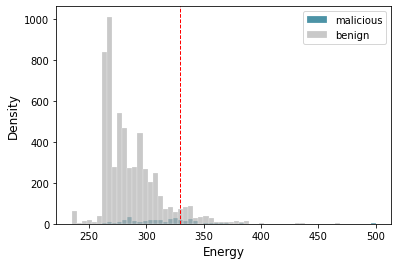

0    720
1    720
Name: Label, dtype: int64
agent16 | cutoff = 324.4376823773045 
-------------------------------------------------------------------
               precision    recall  f1-score   support

           0       0.97      0.94      0.95      7114
           1       0.19      0.34      0.25       308

    accuracy                           0.91      7422
   macro avg       0.58      0.64      0.60      7422
weighted avg       0.94      0.91      0.92      7422



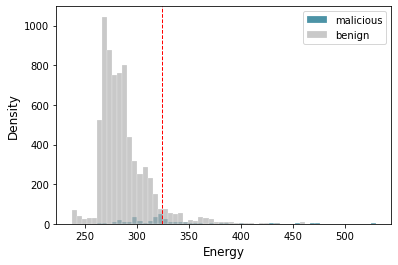

1    2588
0    2588
Name: Label, dtype: int64
agent13 | cutoff = 318.5952762710046 
-------------------------------------------------------------------
               precision    recall  f1-score   support

           0       0.16      0.95      0.27      1109
           1       1.00      1.00      1.00   1292659

    accuracy                           1.00   1293768
   macro avg       0.58      0.97      0.63   1293768
weighted avg       1.00      1.00      1.00   1293768



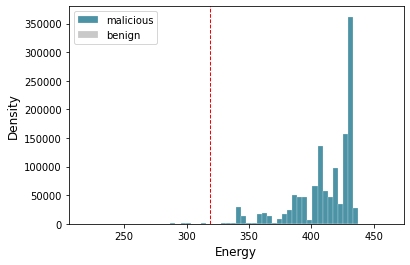

1    997
0    997
Name: Label, dtype: int64
agent9 | cutoff = 303.66008833293887 
-------------------------------------------------------------------
               precision    recall  f1-score   support

           0       1.00      0.91      0.95       427
           1       0.96      1.00      0.98       852

    accuracy                           0.97      1279
   macro avg       0.98      0.95      0.96      1279
weighted avg       0.97      0.97      0.97      1279



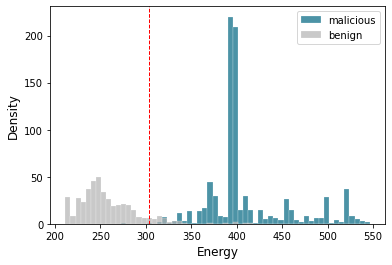

1    3329
0    3329
Name: Label, dtype: int64
agent10 | cutoff = 325.4594638977271 
-------------------------------------------------------------------
               precision    recall  f1-score   support

           0       0.69      0.95      0.80      1427
           1       1.00      1.00      1.00    324891

    accuracy                           1.00    326318
   macro avg       0.84      0.98      0.90    326318
weighted avg       1.00      1.00      1.00    326318



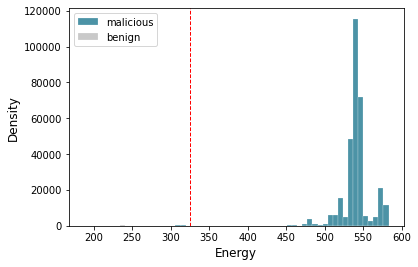

1    2232
0    2232
Name: Label, dtype: int64
agent15 | cutoff = 326.4998278301405 
-------------------------------------------------------------------
               precision    recall  f1-score   support

           0       0.07      0.94      0.13       956
           1       1.00      0.98      0.99    711539

    accuracy                           0.98    712495
   macro avg       0.54      0.96      0.56    712495
weighted avg       1.00      0.98      0.99    712495



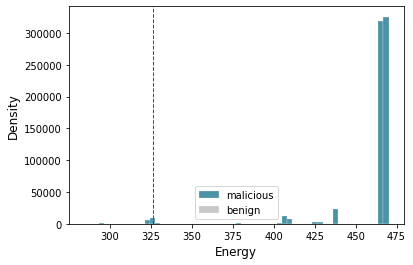

0    66733
1    66733
Name: Label, dtype: int64
agent6 | cutoff = 298.55616883940684 
-------------------------------------------------------------------
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     84614
           1       0.86      1.00      0.93     28600

    accuracy                           0.96    113214
   macro avg       0.93      0.97      0.95    113214
weighted avg       0.97      0.96      0.96    113214



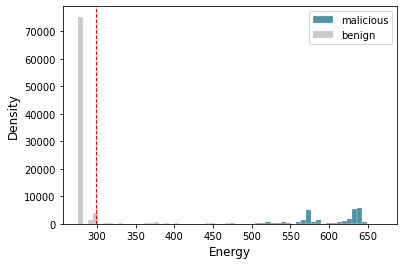

1    2700
0    2700
Name: Label, dtype: int64
agent14 | cutoff = 304.41106205334336 
-------------------------------------------------------------------
               precision    recall  f1-score   support

           0       0.08      0.94      0.14      1157
           1       1.00      0.98      0.99    849477

    accuracy                           0.98    850634
   macro avg       0.54      0.96      0.57    850634
weighted avg       1.00      0.98      0.99    850634



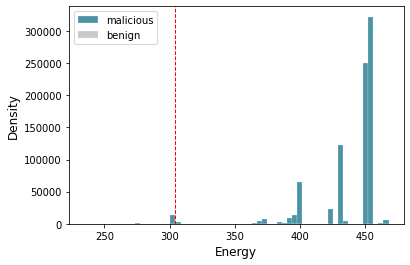

0    761
1    761
Name: Label, dtype: int64
agent17 | cutoff = 318.2938990791466 
-------------------------------------------------------------------
               precision    recall  f1-score   support

           0       0.96      0.93      0.95      6319
           1       0.15      0.22      0.18       326

    accuracy                           0.90      6645
   macro avg       0.55      0.58      0.56      6645
weighted avg       0.92      0.90      0.91      6645



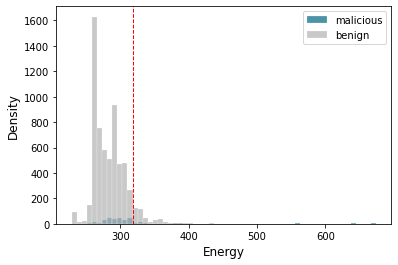

1    207863
0    207863
Name: Label, dtype: int64
agent3 | cutoff = 324.2093071980253 
-------------------------------------------------------------------
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     89084
           1       0.95      1.00      0.98     91792

    accuracy                           0.98    180876
   macro avg       0.98      0.97      0.98    180876
weighted avg       0.98      0.98      0.98    180876



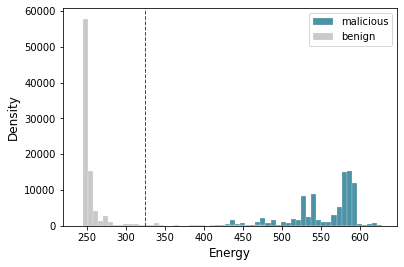

1    45436
0    45436
Name: Label, dtype: int64
agent1 | cutoff = 376.92564477070675 
-------------------------------------------------------------------
               precision    recall  f1-score   support

           0       0.76      0.95      0.85     19473
           1       1.00      0.99      0.99    445716

    accuracy                           0.99    465189
   macro avg       0.88      0.97      0.92    465189
weighted avg       0.99      0.99      0.99    465189



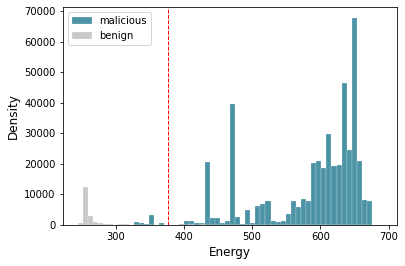

0    146
1    146
Name: Label, dtype: int64
agent2 | cutoff = 316.5126054810896 
-------------------------------------------------------------------
               precision    recall  f1-score   support

           0       1.00      0.86      0.93    216473
           1       0.00      1.00      0.00        62

    accuracy                           0.86    216535
   macro avg       0.50      0.93      0.47    216535
weighted avg       1.00      0.86      0.93    216535



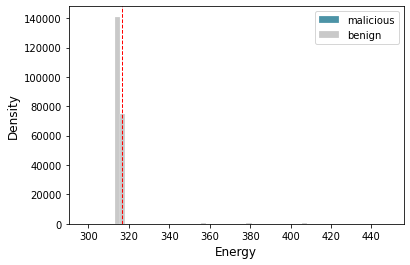

0    3631
1    3631
Name: Label, dtype: int64
agent4 | cutoff = 313.62784199048156 
-------------------------------------------------------------------
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    186216
           1       0.15      1.00      0.25      1556

    accuracy                           0.95    187772
   macro avg       0.57      0.97      0.61    187772
weighted avg       0.99      0.95      0.97    187772



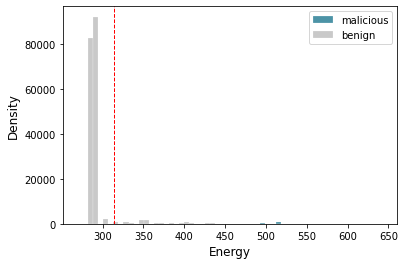

1    21778
0    21778
Name: Label, dtype: int64
agent12 | cutoff = 324.0699013562604 
-------------------------------------------------------------------
               precision    recall  f1-score   support

           0       0.22      0.94      0.36      9333
           1       1.00      0.99      0.99   2644645

    accuracy                           0.99   2653978
   macro avg       0.61      0.97      0.68   2653978
weighted avg       1.00      0.99      0.99   2653978



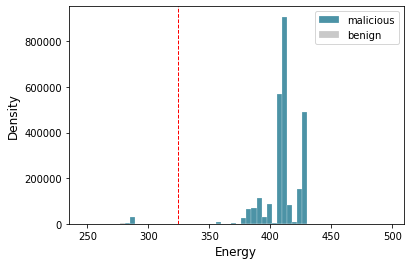

In [7]:
siloed_feat_efc = {}

for key, silo in silos.items():
    
    X = silo.drop(columns=features_to_delete).copy()
    X = preprocess(X)
    y = silo["Label"].copy()
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=42, stratify=y, shuffle=True, test_size=0.3
    )
    
    X_train["Label"] = y_train 
    X_train = rebalance_agent(X_train) 
    y_train = X_train["Label"] 
    X_train = X_train.drop(columns="Label").copy() 
    
    # train and test EFC
    clf = EnergyBasedFlowClassifier(cutoff_quantile=0.95)
    print(y_train.value_counts())
    clf.fit(X_train, y_train)
    
    siloed_feat_efc[key] = clf
    
    y_pred, y_energies = clf.predict(X_test, return_energies=True)
    
    print(key, "| cutoff =", clf.estimators_[0].cutoff_, "\n-------------------------------------------------------------------\n", classification_report(y_test, y_pred))
    
    # ploting energies
    benign = np.where(y_test == 0)[0]
    malicious = np.where(y_test == 1)[0]

    benign_energies = y_energies[benign]
    malicious_energies = y_energies[malicious]
    cutoff = clf.estimators_[0].cutoff_

    bins = np.histogram(y_energies, bins=60)[1]

    plt.hist(
        malicious_energies,
        bins,
        facecolor="#006680",
        alpha=0.7,
        ec="white",
        linewidth=0.3,
        label="malicious",
    )
    plt.hist(
        benign_energies,
        bins,
        facecolor="#b3b3b3",
        alpha=0.7,
        ec="white",
        linewidth=0.3,
        label="benign",
    )
    plt.axvline(cutoff, color="r", linestyle="dashed", linewidth=1)
    plt.legend()

    plt.xlabel("Energy", fontsize=12)
    plt.ylabel("Density", fontsize=12)

    plt.show()
    

In [ ]:
data_feat = {}
full_feat = []
avg_feat_info = {} 

for model_key, model in siloed_feat_efc.items():
    
    silos_y_test = np.array([]) 
    silos_y_pred = np.array([]) 
    
    for key, silo in silos.items():
        #if model_key == key:
        #    continue
            
        X = silo.drop(columns=features_to_delete).copy()
        #X.dropna(inplace=True)
        X = preprocess(X)
        y = silo["Label"].copy()
    
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, random_state=42, stratify=y, shuffle=True, test_size=0.3
        )
        
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred)
        
        silos_y_test = np.concatenate((silos_y_test, y_test), axis=None)
        silos_y_pred = np.concatenate((silos_y_pred, y_pred), axis=None)
        
        data_feat[key] = score
    
    print(f"{model_key} >>> ")
    print(confusion_matrix(silos_y_test, silos_y_pred))
        
    full_feat.append(data_feat)
    avg_feat_info[model_key] = data_feat
    data_feat = {}

agent18 >>> 
[[ 799947  143526]
 [ 399129 6124981]]
agent11 >>> 
[[ 847245   96228]
 [5005973 1518137]]
agent8 >>> 
[[ 851589   91884]
 [5581175  942935]]
agent7 >>> 
[[ 729902  213571]
 [     10 6524100]]
agent5 >>> 
[[ 826706  116767]
 [4075524 2448586]]
agent19 >>> 
[[ 336596  606877]
 [ 361402 6162708]]


KeyboardInterrupt: 

In [ ]:
cross_silo_feat_efc = pd.DataFrame(full_feat, index=list(siloed_feat_efc.keys()))

In [ ]:
plt.figure(figsize = (20,16))
ax = sns.heatmap(cross_silo_feat_efc, xticklabels=cross_silo_feat_efc.columns, yticklabels=cross_silo_feat_efc.columns, annot=True)

In [ ]:
# Calculo da média do modelo de cada um dos agentes avaliado em outros datasets
average_f1_feat_score = dict()

for i in range(len(avg_feat_info)):
    name = "agent" + str(i+1)
    average_f1_feat_score[name] = average(avg_feat_info[name].values())

for name, value in average_f1_feat_score.items():
    print(value)

## Validação entre os silos utilizando feature selection

In [ ]:
agents = silos.copy()
seed = 42

### FedAvg hyperparameters

In [ ]:
rounds = 50

# Epochs
# FedAvg requires a minimum number of training epochs before averaging
# For epoch=1 is the same as FedSGD (https://www.cs.cornell.edu/~shmat/shmat_ccs15.pdf)
epochs = 20

# train_size same as batch size
# If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split. 
# If int, represents the absolute number of train samples
train_size=100 #0.05

remove_agents = []

### Auxiliary Functions

In [ ]:
def process_results(results, remove_list=[]):
    all_values = []
    for major_key in results.keys():
        if (major_key in remove_list) in remove_list:
            continue
        values = []
        for key in agents.keys():
            if key in remove_list:
                continue
            values.append(results[major_key][key])
        all_values.append(values)
    return all_values

In [ ]:
# update each agent model by current global model values
def load_global_model(model):
    model.intercept_ = fedavg.intercept_.copy()
    model.coef_ = fedavg.coef_.copy()
    return model

In [ ]:
def update_global_model(applicable_models, round_weights):
    # Average models parameters
    coefs = []
    intercept = []
    for model in applicable_models:
        coefs.append(model.coef_)
        intercept.append(model.intercept_)
    
    # average and update FedAvg (aggregator model)
    fedavg.coef_ = np.average(coefs, axis=0, weights=round_weights) # weight
    fedavg.intercept_ = np.average(intercept, axis=0, weights=round_weights) # weight

In [ ]:
def train_local_agent(X, y, model, epochs, class_weight):
    for _ in range(0, epochs):
        model.partial_fit(X, y, classes=np.unique(y), sample_weight=class_weight)
    return model

In [ ]:
# update each agent model by current global model values
def load_global_model(model):
    model.intercept_ = fedavg.intercept_.copy()
    model.coef_ = fedavg.coef_.copy()
    return model

In [ ]:
def update_global_model(applicable_models, round_weights):
    # Average models parameters
    coefs = []
    intercept = []
    for model in applicable_models:
        coefs.append(model.coef_)
        intercept.append(model.intercept_)
    
    # average and update FedAvg (aggregator model)
    fedavg.coef_ = np.average(coefs, axis=0, weights=round_weights) # weight
    fedavg.intercept_ = np.average(intercept, axis=0, weights=round_weights) # weight

In [ ]:
def train_local_agent(X, y, model, epochs, class_weight):
    for _ in range(0, epochs):
        model.partial_fit(X, y, classes=np.unique(y), sample_weight=class_weight)
    return model

### Global Model

In [ ]:
fedavg = SGDClassifier() 
lr = 0.1
def initialize_global_model(agent, features_to_drop):
    lr = 0.1
    fedavg = SGDClassifier(n_jobs=-1, random_state=seed, loss="log", learning_rate='constant', eta0=lr, verbose=0) # global
    features = agent.drop(columns=features_to_drop).shape[1] # total number of features
    fedavg.intercept_ = np.zeros(1)
    fedavg.coef_ = np.zeros((1, features))
    fedavg.classes_ = np.array([0, 1])
    return fedavg

In [ ]:
sgd_feature = dict()
for agent in agents.keys():
    sgd_feature[agent] = SGDClassifier(n_jobs=-1, random_state=seed, loss="log", learning_rate='constant', eta0=lr, verbose=0)

In [ ]:
fedavg = initialize_global_model(agents["agent1"], features_to_delete)

### Benign Samples

In [ ]:
rounds_f1_score = dict() 

print("Federated Training Started.")
for r in range(rounds):
    sample_size = random.randint(int(len(agents)/2), len(agents))
    applicable_agents = random.sample(list(agents.keys()), k=sample_size) # select random agents/silos

    applicable_models = []
    applicable_name = []

    round_weights = []
    dataset_size = 0

    for name, agent in agents.items():
        if name not in applicable_agents: # check if agent/silos is in applicable_agents
            continue

        if name in remove_agents: # check if agent/silos is in remove_agents, if yes, jump (refer to FedAvg hyperparams)
            continue
        
        prep = StandardScaler() 
        applicable_name.append(name)

        agent_balanced = rebalance_agent(agent)
        
        print(".", end=" ")
        X = agent_balanced.drop(columns=features_to_delete)
        y = agent_balanced.Label
      
        X = preprocess(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=train_size, stratify=y) #stratified / random_state=seed
        X_train = prep.fit_transform(X_train)

        dataset_size += X_train.shape[0]

        sample_weights = compute_sample_weight('balanced', y=y_train)
        sgd_feature[name] = load_global_model(sgd_feature[name])
        sgd_feature[name] = train_local_agent(X_train, y_train, sgd_feature[name], epochs, sample_weights)
        round_weights.append(X_train.shape[0])
        applicable_models.append(sgd_feature[name])

    round_weights = np.array(round_weights) / dataset_size # calculate weight based on actual dataset size

    try:
        update_global_model(applicable_models, round_weights)
    except:
        print("Error updating global model, due to division by 0")
    
    for name, agent in agents.items():
        sgd_feature[name] = load_global_model(sgd_feature[name])

In [ ]:
cross_validation_results = dict()

print("Cross Validation Analisys Started...")
for name, agent in agents.items():
    
    silos_y_test = np.array([]) 
    silos_y_pred = np.array([])
    
    print(".", end="")
    if name in remove_agents:
            continue
            
    agent_balanced = rebalance_agent(agent) 
    
    X = agent_balanced.drop(columns=features_to_delete)
    y = agent_balanced.Label

    X = preprocess(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified
    
    X_train = prep.fit_transform(X_train)
    X_test = prep.transform(X_test) 
    
    y_pred = sgd_feature[name].predict(X_test)
    
    cross_validation_results[name] = dict()
    cross_validation_results[name][name] = f1_score(y_test, y_pred, average="binary")
    
    print(name + " " + str(cross_validation_results[name][name]))
    
    silos_y_test = np.concatenate((silos_y_test, y_test), axis=None)
    silos_y_pred = np.concatenate((silos_y_pred, y_pred), axis=None)
    
    for test_name, test_agent in agents.items():
        if test_name == name:
            continue
        
        X = test_agent.drop(columns=features_to_delete)
        y = test_agent.Label
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified
        X_test = preprocess(X_test)
        X_test = prep.transform(X_test)
        
        y_pred = sgd_feature[name].predict(X_test)
        cross_validation_results[name][test_name] = f1_score(y_test, y_pred, average="binary")
        
        silos_y_test = np.concatenate((silos_y_test, y_test), axis=None)
        silos_y_pred = np.concatenate((silos_y_pred, y_pred), axis=None)
    
    print(f"{name} >>> ")
    print(confusion_matrix(silos_y_test, silos_y_pred))

In [ ]:
feature_results = process_results(cross_validation_results, remove_agents)

In [ ]:
labels = [i for i in agents.keys() if i not in remove_agents]
plt.figure(figsize = (30,15))
ax = sns.heatmap(feature_results, vmin=0, vmax=1, annot=True, fmt=".4f", xticklabels=labels, yticklabels=labels, cmap="YlGnBu")

In [ ]:
average_f1_score = dict()
for i, name in enumerate(agents.keys()):
    average_f1_score[name] = average(feature_results[i])

for value in average_f1_score.values():
    print(value)

# Evaluation models by combining EFC + Federated Learning Model

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

Combination of the models using **OR** operation 

In [ ]:
cross_validation_results = dict()

print("Cross Validation Analisys Started...")
for name, agent in agents.items():
    
    silos_y_test = np.array([]) 
    silos_y_pred = np.array([])
    
    print(".", end="")
    if name in remove_agents:
            continue
            
    agent_balanced = rebalance_agent(agent) 
    
    X = agent_balanced.drop(columns=features_to_delete)
    y = agent_balanced.Label

    X = preprocess(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified
    
    X_train = prep.fit_transform(X_train)
    X_test = prep.transform(X_test) 
    
    y_pred_federated = sgd_feature[name].predict(X_test)
    y_pred_efc = siloed_feat_efc[name].predict(X_test) 
    
    y_pred = np.logical_or(y_pred_federated, y_pred_efc)
    
    silos_y_test = np.concatenate((silos_y_test, y_test), axis=None)
    silos_y_pred = np.concatenate((silos_y_pred, y_pred), axis=None)
    
    cross_validation_results[name] = dict()
    cross_validation_results[name][name] = f1_score(y_test, y_pred, average="binary")
    
    print(name + " " + str(cross_validation_results[name][name]))
    
    for test_name, test_agent in agents.items():
        if test_name == name:
            continue
        
        X = test_agent.drop(columns=features_to_delete)
        y = test_agent.Label
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified
        X_test = preprocess(X_test)
        X_test = prep.transform(X_test)
        
        y_pred_federated = sgd_feature[name].predict(X_test)
        y_pred_efc = siloed_feat_efc[name].predict(X_test)
        
        y_pred = np.logical_or(y_pred_federated, y_pred_efc)
        
        silos_y_test = np.concatenate((silos_y_test, y_test), axis=None)
        silos_y_pred = np.concatenate((silos_y_pred, y_pred), axis=None)
        
        cross_validation_results[name][test_name] = f1_score(y_test, y_pred, average="binary")
    
    print(f"{name} >>> ")
    cm = confusion_matrix(silos_y_test, silos_y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    

In [ ]:
array_valores_01 = np.array([0,0,0])
array_valores_02 = np.array([1,0,0])

print(np.logical_or(array_valores_01, array_valores_02))

In [ ]:
feature_results = process_results(cross_validation_results, remove_agents)

In [ ]:
labels = [i for i in agents.keys() if i not in remove_agents]
plt.figure(figsize = (30,15))
ax = sns.heatmap(feature_results, vmin=0, vmax=1, annot=True, fmt=".4f", xticklabels=labels, yticklabels=labels, cmap="YlGnBu")

In [ ]:
average_f1_score = dict()
for i, name in enumerate(agents.keys()):
    average_f1_score[name] = average(feature_results[i])

for value in average_f1_score.values():
    print(value)

Combination of the models using **AND** operation 

In [ ]:
cross_validation_results = dict()

print("Cross Validation Analisys Started...")
for name, agent in agents.items():
    
    silos_y_test = np.array([]) 
    silos_y_pred = np.array([])
    
    print(".", end="")
    if name in remove_agents:
            continue
            
    agent_balanced = rebalance_agent(agent) 
    
    X = agent_balanced.drop(columns=features_to_delete)
    y = agent_balanced.Label

    X = preprocess(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified
    
    X_train = prep.fit_transform(X_train)
    X_test = prep.transform(X_test) 
    
    y_pred_federated = sgd_feature[name].predict(X_test)
    y_pred_efc = siloed_feat_efc[name].predict(X_test) 
    
    y_pred = np.logical_and(y_pred_federated, y_pred_efc)
    
    silos_y_test = np.concatenate((silos_y_test, y_test), axis=None)
    silos_y_pred = np.concatenate((silos_y_pred, y_pred), axis=None)

    cross_validation_results[name] = dict()
    cross_validation_results[name][name] = f1_score(y_test, y_pred, average="binary")
    
    print(name + " " + str(cross_validation_results[name][name]))
    
    for test_name, test_agent in agents.items():
        if test_name == name:
            continue
        
        X = test_agent.drop(columns=features_to_delete)
        y = test_agent.Label
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified
        X_test = preprocess(X_test)
        X_test = prep.transform(X_test)
        
        y_pred_federated = sgd_feature[name].predict(X_test)
        y_pred_efc = siloed_feat_efc[name].predict(X_test)
        
        y_pred = np.logical_and(y_pred_federated, y_pred_efc)
        
        silos_y_test = np.concatenate((silos_y_test, y_test), axis=None)
        silos_y_pred = np.concatenate((silos_y_pred, y_pred), axis=None)
        
        cross_validation_results[name][test_name] = f1_score(y_test, y_pred, average="binary")
    
    print(f"{name} >>> ")
    cm = confusion_matrix(silos_y_test, silos_y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()


In [ ]:
feature_results = process_results(cross_validation_results, remove_agents)

In [ ]:
labels = [i for i in agents.keys() if i not in remove_agents]
plt.figure(figsize = (30,15))
ax = sns.heatmap(feature_results, vmin=0, vmax=1, annot=True, fmt=".4f", xticklabels=labels, yticklabels=labels, cmap="YlGnBu")

In [ ]:
average_f1_score = dict()
for i, name in enumerate(agents.keys()):
    average_f1_score[name] = average(feature_results[i])

for value in average_f1_score.values():
    print(value)